In [51]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

%config InlineBackend.figure_format = "svg"
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [82]:
def moran_rgt(tmax,divide,\
    cells_init,ax,*,max_steps = 10**4,\
    div_params = None,\
    stop_cond = lambda x: False):
    """
    Simulates neutral competition between two species

    Input
    ---------
    tmax - time to simulate
    divide - function specifying how division times are generated
    cells_init - initial state of system. Each cell is represented by a
            numpy array of the form [time of division,gen. time,species].
            species is 0 or 1 for a two species model. This means
            cells_init[5,1] would give the 6th cell's generation time

    optional inputs:
    max_steps - max divisions to record
    dt_sample - time between points to sample, because
                we usually don't want to save all point.
                ignotes if save_all = True
    div_params - paramaters to pass to divide function

    Ouput
    ---------
    t  - numpy array of division times
    n1 - numpy array of the number of cells of species 1
    cells - the list of cells at the time when the simulation ended
    """
    def color_func(cell_type):
      return "C%d"%cell_type

    n1  = np.zeros(max_steps)
    t = np.zeros(max_steps)
    steps = 1
    t_last = 0. # time of last division
    cells = copy.deepcopy(cells_init)
    ntot = len(cells[:,0])
    n1[0] = np.sum([cells[:,2]])
    history = np.zeros((max_steps,ntot))
    history[0,:] = cells[:,2]


    while t_last<tmax and steps-1<max_steps and stop_cond(n1[steps-1])==False:
        ind = np.argmin(cells[:,0]) # can this be made more efficient?
        mother_dt   = cells[ind,0] # division time of dividing cell
        mother_gt   = cells[ind,1] # generation time of dividing cell
        mother_type = cells[ind,2] # type of dividing cell

        if mother_dt-t_last <0.1: # this is too prevent divisions too close together
          cells[ind,0] = cells[ind,0] + 0.2
          cells[ind,1] = cells[ind,1] + 0.2
        else:

          t_last = mother_dt # current time is now division time

          gtL,gtR = divide(mother_gt,div_params,mother_type) # get daughter cell generation times

          cellL = np.array([t_last+gtL,gtL,mother_type]) # make "left" daughter
          cellR = np.array([t_last+gtR,gtR,mother_type]) # make "right" daughter
          cells[ind,:] = cellL # one of the daughters goes where the mother was
          ax.plot([t[steps-1],t_last],[ind/ntot,ind/ntot],"-",color=color_func(history[steps-1,ind]))
          


          ind2 = np.random.choice(ntot) # index of cell to kick out
          
          while ind2 == ind:
            ind2 = np.random.choice(ntot) 
          ax.plot([t[steps-1]],[ind2/ntot],".",color=color_func(history[steps-1,ind2]))

          cells[ind2] = cellR
          if ind2 == ind +1:
            cells[ind+1] = cellR
            ax.plot([t[steps-1],t_last],[ind/ntot,ind2/ntot],"-",color=color_func(history[steps-1,ind]))

          elif ind2 == ind -1:
            cells[ind-1] = cellR
            ax.plot([t[steps-1],t_last],[ind/ntot,ind2/ntot],"-",color=color_func(history[steps-1,ind]))
          elif ind2 > ind+1:
            cells[ind+2:ind2+1,:] = cells[ind+1:ind2,:]
            for k in range(ind+1,ind2):
              ax.plot([t[steps-1],t_last],[k/ntot,(k+1)/ntot],"-",color=color_func(history[steps-1,k]))
            cells[ind+1] = cellR
            ax.plot([t[steps-1],t_last],[ind/ntot,(ind+1)/ntot],"-",color=color_func(history[steps-1,ind]))
          else:
            cells[ind2:ind-1,:] = cells[ind2+1:ind,:]
            for k in range(ind2+1,ind):
              ax.plot([t[steps-1],t_last],[k/ntot,(k-1)/ntot],"-",color=color_func(history[steps-1,k]))
            cells[ind-1] = cellR
            ax.plot([t[steps-1],t_last],[ind/ntot,(ind-1)/ntot],"-",color=color_func(history[steps-1,ind]))
      

 
          for k in range(np.max([ind,ind2])+1,ntot):
              ax.plot([t[steps-1],t_last],[k/ntot,k/ntot],"-",color=color_func(history[steps-1,k]))

          for k in range(0,np.min([ind,ind2])):
              ax.plot([t[steps-1],t_last],[k/ntot,k/ntot],"-",color=color_func(history[steps-1,k]))


          t[steps] = t_last
          n1[steps] = np.sum([cells[:,2]])
          history[steps,:] = cells[:,2]
          steps+=1

        
    return t[0:steps],n1[0:steps],np.sort(np.array(history[0:steps]),axis=1)

In [83]:
def divide(mother_gt,div_params,mother_type):
  #return np.random.exponential(1),np.random.exponential(1)
  return np.random.normal(1,0.1),np.random.normal(1,0.1)

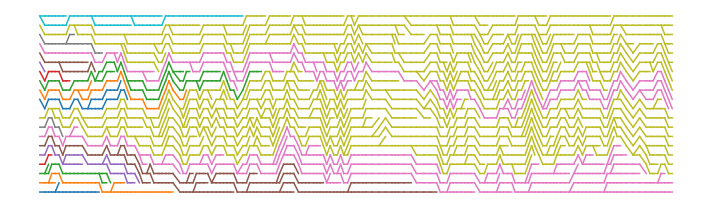

In [54]:
n_cells= 20
div_times= np.random.exponential(1,n_cells)
cells_init = np.array([[div_times[k],div_times[k],k] for k in range(n_cells)])
#cells_init[4,2] = 1

fig,ax = plt.subplots(figsize=(10,3))
t,n,history = moran_rgt(n_cells,divide,cells_init,ax)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.gca().axison = False
plt.tight_layout()
#plt.savefig("./../figures/lineages1.svg")

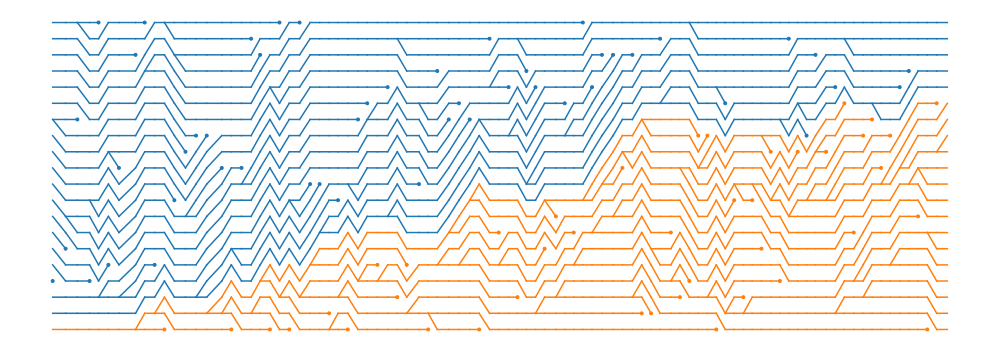

In [95]:
def divide(mother_gt,div_params,mother_type):
    if mother_type ==0:
        return np.random.exponential(1),np.random.exponential(1)
    else:
        return np.random.exponential(.05),np.random.exponential(.05)

n_cells= 20
div_times= np.random.exponential(1,n_cells)
cells_init = np.array([[div_times[k],div_times[k],0] for k in range(n_cells)])
cells_init[0,2] = 1

fig,ax = plt.subplots(figsize=(14,5))
t,n,history = moran_rgt(n_cells/2,divide,cells_init,ax)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.gca().axison = False
plt.tight_layout()
#plt.savefig("./../figures/lineages2.svg")

In [70]:
np.random.exponential(1)

2.87973143771973

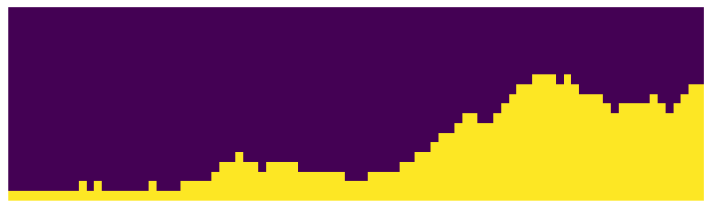

In [88]:
fig,ax = plt.subplots(figsize=(10,3))
ax.imshow(np.transpose(history),aspect='auto')
plt.tight_layout()
plt.gca().axison = False
plt.tight_layout()
#plt.savefig("./../figures/lineages1.svg")

In [63]:
history

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

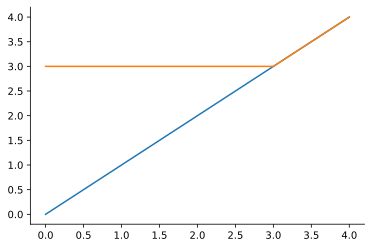

In [ ]:
plt.plot(history[0])
plt.plot(history[10])

In [ ]:
history

array([[0., 1., 2., 3., 4.],
       [3., 1., 2., 3., 4.],
       [3., 1., 4., 3., 4.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

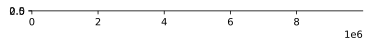

In [ ]:
plt.imshow(np.transpose(history)/5)

In [ ]:
len(history)

10000000

In [ ]:
np.min(0,1)

AxisError: ignored

In [13]:
data = pd.read_csv("R_VS_dk_N200.csv").values[0]

In [17]:
cv = np.linspace(0.1,1,len(data))

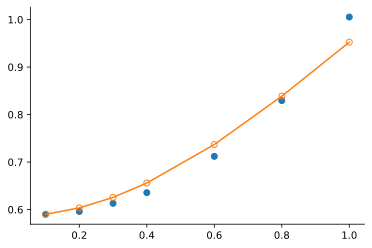

In [50]:
plt.plot(cv,data,"o")
def fix(c):
    return 1/c**2*(1-2**(-c**2))
plt.plot(cv,[data[0] - 1.9*(fix(c)  -fix(0.1)) for c in cv],"o-",fillstyle="none")

In [21]:
cv  = np.array([0.1,0.2,0.3,0.4,0.6,0.8,1.])